# Assignment 2: Hybrid Images and Scale-space blob detection

In [1]:
# Libraries you will find useful
import numpy as np
import scipy 
import skimage
import skimage.io
import skimage.transform
import matplotlib.pyplot as plt

## Part 1: Hybrid Images

In [2]:
# Crop and align the images such that the objects and their edges are aligned. 
# You are free to use any image editing tool for this and there is no need for code for this step.

# Load cropped and aligned images
def load_image(image, mode="gray"):
    im = skimage.io.imread(image, as_gray=mode=="gray")
    return im

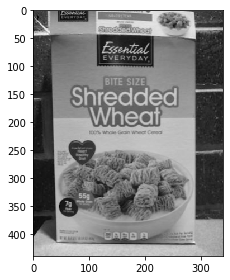

In [3]:
# Read aligned input images and convert them to grayscale 
# crop_im_size = (340, 440)
img1, img2 = "c1_crop.png", "c2_crop.png"
# img1, img2 = "human_face_crop.png", "dog_face_crop.png"
# img1, img2 = "horse.jpeg", "zebra.jpeg"
# img1, img2 = "cat.png", "dog_2.png"
im1 = load_image(img1)
im2 = load_image(img2)
# im = np.concatenate([im1, im2], axis=1)
skimage.io.imshow(im1)

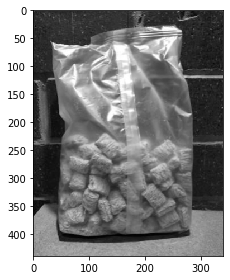

In [4]:
skimage.io.imshow(im2)

In [5]:
# Apply a low-pass filter, i.e., a standard 2D Gaussian filter, on the first (smooth) image. 
from scipy.ndimage import gaussian_filter

def low_pass_filter(image, sigma):
    return gaussian_filter(image, sigma)


In [6]:
# Apply a high-pass filter on the second image. 
# The paper suggests using an impulse (identity) filter minus a Gaussian filter for this operation.
def high_pass_filter(image, sigma):
    return image - gaussian_filter(image, sigma)


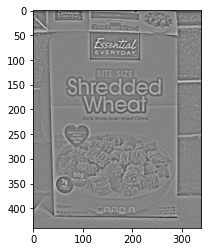

In [7]:
# Use your intuition and trial and error to determine good values of σ for the high-pass and low-pass filters
# One of the σ's should always be higher than the other (which one?), but the optimal values can vary from image to image.
sigma_h = 3 # for c
# sigma_l = 7
# sigma_l = 7
fil_im1 = high_pass_filter(im1, sigma_h)
plt.imshow(fil_im1, cmap="gray")
plt.show()


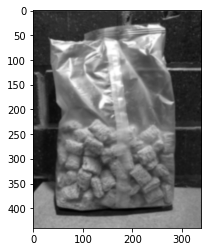

In [8]:
sigma_l = 1 # for c
# sigma_h = 3
# sigma_h = 3
fil_im2 = low_pass_filter(im2, sigma_l)
plt.imshow(fil_im2, cmap="gray")
plt.show()

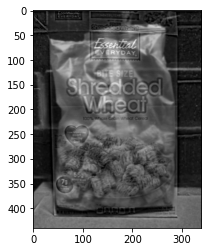

In [9]:
# Add or average the tranformed images to create the hybrid image.
hybrid = (fil_im1 + fil_im2)/2
hybrid = np.clip(hybrid, 0, 1)
plt.imshow(hybrid, cmap="gray")
plt.show()

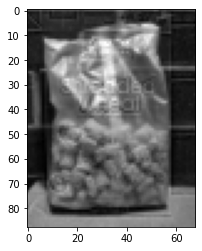

In [10]:
# rescale image
rescale_hybrid = skimage.transform.rescale(hybrid, 0.2)
plt.imshow(rescale_hybrid, cmap="gray")

In [11]:
#### Extra 1 for hybrid image
# load colorful image
imc1 = load_image(img1, mode="color")
imc2 = load_image(img2, mode="color")
# convert rgba to rgb
if imc1.shape[-1] == 4:
    imc1 = imc1[:, :, :3]
if imc2.shape[-1] == 4:
    imc2 = imc2[:, :, :3]

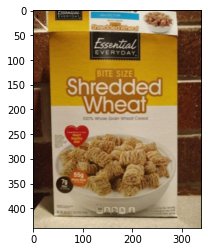

In [12]:
plt.imshow(imc1)

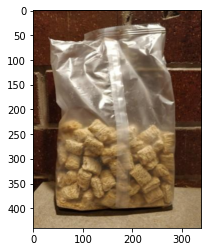

In [13]:
plt.imshow(imc2)

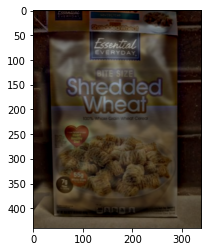

In [14]:
imc1 = imc1.astype(np.float)
imc2 = imc2.astype(np.float) 
# high pass each color channel of im1
sigma_h = 11
imc1_r, imc1_g, imc1_b = imc1[:, :, 0], imc1[:, :, 1], imc1[:, :, 2]
imc1_r_fil = high_pass_filter(imc1_r, sigma_h)
imc1_g_fil = high_pass_filter(imc1_g, sigma_h)
imc1_b_fil = high_pass_filter(imc1_b, sigma_h)

# low pass each color channel of im2
sigma_l = 3
imc2_r, imc2_g, imc2_b = imc2[:, :, 0], imc2[:, :, 1], imc2[:, :, 2]
imc2_r_fil = low_pass_filter(imc2_r, sigma_l)
imc2_g_fil = low_pass_filter(imc2_g, sigma_l)
imc2_b_fil = low_pass_filter(imc2_b, sigma_l)

# plt.imshow(imc1_r_fil)

# hybrid image 
hyb_r = (imc1_r_fil + imc2_r_fil)/2
hyb_g = (imc1_g_fil + imc2_g_fil)/2
hyb_b = (imc1_b_fil + imc2_b_fil)/2
hyb = np.zeros_like(imc1)
hyb[:, :, 0] = hyb_r
hyb[:, :, 1] = hyb_g 
hyb[:, :, 2] = hyb_b
hyb = np.clip(hyb, 0, 255)
hyb = hyb.astype(np.uint8)
plt.imshow(hyb)
plt.show()

In [15]:
###### Extra 2 for hybrid image
import cv2 

# resize image
target_size = (280, 360)
im1 = cv2.resize(im1, target_size)
im2 = cv2.resize(im2, target_size)
def gaussian_laplacian_pyramid(image, layers=3):
    gau_pyr = [image]
    for i in range(layers):
        image = cv2.pyrDown(image)
        gau_pyr.append(image)
    lap_pyr = [gau_pyr[-1]]
    for i in range(-1, -4, -1):
        size = gau_pyr[i-1].shape[::-1] # col * rows
        # print(size, gau_pyr[i].shape)
        recon = cv2.pyrUp(gau_pyr[i], dstsize=size)
        lap = gau_pyr[i-1] - recon
        lap_pyr.append(lap)
    return gau_pyr + lap_pyr


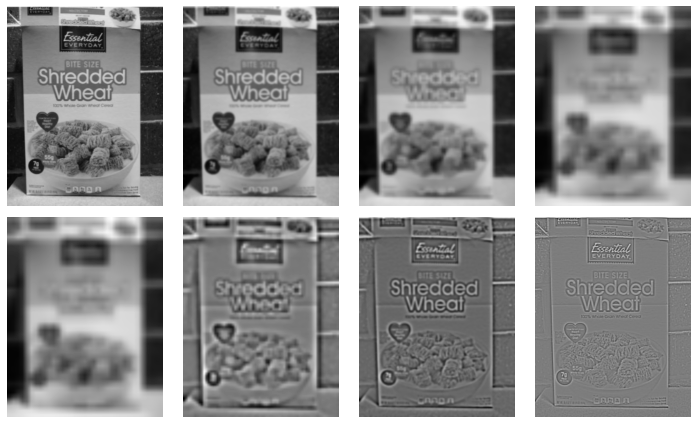

In [16]:
img_pyr = gaussian_laplacian_pyramid(im1)
images = [cv2.resize(x, target_size) for x in img_pyr]

fig, axes = plt.subplots(2, 4)
fig.set_size_inches(10, 6)
for i, img in enumerate(images):
    axes[i//4, i%4].imshow(img, cmap="gray")
    axes[i//4, i%4].axis('off')
fig.tight_layout()
plt.show()

## Part 2: Scale-space blob detection

In [17]:
# convert images to grayscale
# rescale the intensities to between 0 and 1 (simply divide them by 255 should do the trick)
def load_gray_image(image):
    im = skimage.io.imread(image, as_gray=True)
    return im

In [18]:
# Creating the Laplacian filter
# Pay careful attention to setting the right filter mask size. Hint: Should the filter width be odd or even?
from scipy.ndimage.filters import gaussian_laplace

def laplacian_filter(image, sigma, kernel_size=None):
    if kernel_size:
        t = ((kernel_size-1)//2-0.5)/sigma # see: https://github.com/scipy/scipy/blob/v1.7.1/scipy/ndimage/filters.py#L258
        return gaussian_laplace(image, sigma, truncate=t)
    else:
        # t = 1.75
        t = 4.0 # default
        return gaussian_laplace(image, sigma, truncate=t)



In [19]:
# filtering the image (two implmementations)
# one that increases filter size, and one that downsamples the image
# For timing, use time.time()
def blob_detect(image, sigma, k=np.sqrt(2), levels=10, method="up", kernel_size=9):
    h, w = image.shape
    scale_space = np.empty((h, w, levels), dtype=np.float)
    if method == "up": # upscale kernel size
        for i in range(levels):
            # need to norm with sigma^2 because of derivative calculation
            scale_space[:, :, i] = np.power((laplacian_filter(image, sigma)*sigma**2), 2) # save square of laplacian response
            sigma = sigma*k
    elif method == "down":
        # need to fix kernel size
        space_scale = 1.
        for i in range(levels):
            space_size = (int(h*space_scale), int(w*space_scale))
            space_image = skimage.transform.resize(image, space_size, anti_aliasing=True)
            # filter. No need sigma^2 since the kernel remains same.
            fil_image = np.power(laplacian_filter(space_image, sigma, kernel_size=kernel_size), 2)
            fil_image = skimage.transform.resize(fil_image, (h, w), anti_aliasing=True)
            scale_space[:, :, i] = fil_image 
            space_scale /= k
    return scale_space
    

In [20]:
# nonmaximum suppression in scale space
# you may find functions scipy.ndimage.filters.rank_filter or scipy.ndimage.filters.generic_filter useful
from scipy.ndimage.filters import rank_filter, generic_filter, maximum_filter
import time

def nms(scale_space, thres=0.3):
    nms_space = np.zeros_like(scale_space)
    levels = scale_space.shape[-1]
    t = time.time()
    # nms on each slice
    kernel_size = 7
    for i in range(levels):
        # roi = int(roi * k ** i)
        max_fil_image = rank_filter(scale_space[:, :, i], rank=-1, size=(kernel_size, kernel_size))
        # max_fil_image = maximum_filter(scale_space[:, :, i], size=size)
        # max_fil_image = generic_filter(scale_space[:, :, i], size=roi, function=np.max)
        nms_space[:, :, i] = max_fil_image
    print("max filter time: ", time.time() - t)
    # max filter all
    # nms on all levels
    max_space = np.max(nms_space, axis=-1)
    # above given thres 
    detected_space = np.zeros_like(nms_space, dtype=np.float)
    for i in range(levels):
        detected_space[:, :, i] = (scale_space[:, :, i] == max_space) * scale_space[:, :, i]
    # remove borders
    border = (kernel_size - 1)//2
    detected_space[:border, :, :] = 0
    detected_space[-border:, :, :] = 0
    detected_space[:, :border, :] = 0
    detected_space[:, -border:, :] = 0
    detected_space = np.where(detected_space > thres, 1, 0)
    return detected_space


In [21]:
# get circle x, y, radius
def get_circle_info(detected_space, sigma=2, k=np.sqrt(2)):
    levels = detected_space.shape[-1]
    cx, cy, r = [], [], []
    for i in range(levels):
        blob_centers = np.argwhere(detected_space[:, :, i]==1)
        print(len(blob_centers))
        cx += [x[1] for x in blob_centers]
        cy += [x[0] for x in blob_centers]
        r += [np.sqrt(2)*sigma*k**i] * len(blob_centers)
    return cx, cy, r


In [22]:
# To display the detected regions as circle
from matplotlib.patches import Circle

def show_all_circles(image, cx, cy, rad, color='r'):
    """
    image: numpy array, representing the grayscsale image
    cx, cy: numpy arrays or lists, centers of the detected blobs
    rad: numpy array or list, radius of the detected blobs
    """
    fig, ax = plt.subplots()
    ax.set_aspect('equal')
    ax.imshow(image, cmap='gray')
    for x, y, r in zip(cx, cy, rad):
        circ = Circle((x, y), r, color=color, fill=False, lw=2)
        ax.add_patch(circ)

    plt.title('%i circles' % len(cx))
    plt.show()

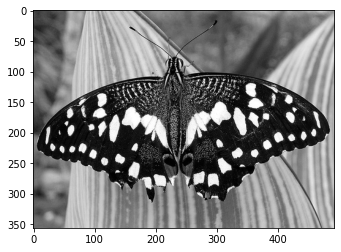

In [23]:
image = 'assignment2_images/butterfly.jpg'
# image = 'assignment2_images/fishes.jpg'
# image = 'assignment2_images/einstein.jpg'
# image = "assignment2_images/sunflowers.jpg"
# image = "assignment2_images/balloons.jpeg"
# image = "assignment2_images/car.jpeg"
# image = "assignment2_images/gandam.jpeg"
# image = "assignment2_images/grapes.jpeg"
method = "up"
sigma = 2
k = np.sqrt(2)
# k = 2
levels = 10
# levels = 12
kernel_size = 9
thres = 0.005

im = load_gray_image(image)
plt.imshow(im, cmap="gray")


Time for up when computing squared laplacian response: 0.4904930591583252
max filter time:  0.05153799057006836
Time for detecting blobs: 0.599869966506958
206
101
87
82
27
22
4
8
5
2


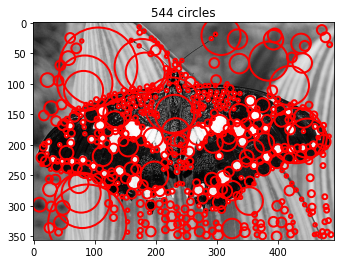

In [24]:
t1 = time.time()
scale_space = blob_detect(im, sigma=sigma, k=k, levels=levels, method=method, kernel_size=kernel_size)
print("Time for {} when computing squared laplacian response: {}".format(method, time.time()-t1))
act_map  = nms(scale_space, thres=thres)
print("Time for detecting blobs: {}".format(time.time()-t1))
cx, cy, rad = get_circle_info(act_map, k=k)
show_all_circles(im, cx, cy, rad)

Time for detecting blobs: 4.807865858078003


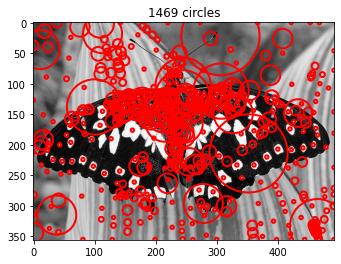

In [25]:
# Extra: DOG
from skimage.feature import blob_dog

t2 = time.time()
blobs_dog = blob_dog(im, min_sigma=1, max_sigma=32, sigma_ratio=np.sqrt(2), threshold=thres)
print("Time for detecting blobs: {}".format(time.time()-t2))
blobs_dog[:, 2] = blobs_dog[:, 2] * np.sqrt(2)
cy = blobs_dog[:, 0]
cx = blobs_dog[:, 1]
r = blobs_dog[:, 2]
show_all_circles(im, cx, cy, rad)

In [84]:
# exp 1
from scipy.ndimage import gaussian_filter

def dog_blob(im, sigma, k, levels, octave):
    h, w = im.shape
    
    for oct in range(0,octave):
        print("current oct %d" %(oct))
        # sigma = sigma * np.power(k, -2*oct)
        if oct == 0:
            octave_shape = im.shape
        else:
            octave_shape = (int(h/oct), int(w/oct))
        cur_octave = skimage.transform.resize(im, octave_shape)
        octave_scale_space = np.zeros((octave_shape[0], octave_shape[1], levels))
        
        for i in range(levels):
            octave_scale_space[:, :, i] = gaussian_filter(cur_octave, sigma)
            sigma *= k
        
        dog_space = np.diff(octave_scale_space, axis=-1)
        dog_space = np.power(dog_space, 2)
        if oct == 0:
            dog_space_1 = dog_space
        if oct == 2:
            dog_space_2 = dog_space
        # if oct == 4:
        #     dog_space_3 = dog_space
        
       
    dog_space_2_ori = np.zeros_like(dog_space_1)
    # dog_space_3_ori = np.zeros_like(dog_space_1)
    # Scale_space resize to oringinal image
    for i in range(levels-1):
        dog_space_2_ori[:, :, i] = skimage.transform.resize(dog_space_2[:,:,i], (h, w))
        # dog_space_3_ori[:, :, i] = skimage.transform.resize(dog_space_3[:,:,i], (h, w))
    
    # diff_space = np.concatenate((dog_space_1, dog_space_2_ori, dog_space_3_ori), axis=-1)
    diff_space = np.concatenate([dog_space_1, dog_space_2_ori], axis=-1)
    print("diff space size:", diff_space.shape)
    return diff_space


In [85]:
# exp 2
from scipy.ndimage import gaussian_filter

def dog_blob2(im, sigma, levels, octave):
    h, w = im.shape
    
    dog_list = []
    cur_octave = im
    for oct in range(0,octave):
        print("current oct %d" %(oct))
        # sigma = sigma * np.power(2, oct)
        if oct == 0:
            octave_shape = im.shape
        else:
            octave_shape = (int(h/np.power(2, oct)), int(w/np.power(2, oct)))
        cur_octave = skimage.transform.resize(cur_octave, octave_shape)
        octave_scale_space = np.zeros((octave_shape[0], octave_shape[1], levels))
        k = np.power(2, 1/levels)
        sig = sigma
        for i in range(levels):
            cur_octave = gaussian_filter(cur_octave, sig)
            octave_scale_space[:, :, i] = cur_octave
            sig *= k
        
        dog_space = np.diff(octave_scale_space, axis=-1)
        dog_space = np.power(dog_space, 2)
        dog_space_ori = np.zeros((h, w, dog_space.shape[-1]))
        # Scale_space resize to original image
        for i in range(levels-1):
            dog_space_ori[:, :, i] = skimage.transform.resize(dog_space[:,:,i], (h, w))
        dog_list.append(dog_space_ori)
        
    # diff_space = np.concatenate((dog_space_1, dog_space_2_ori, dog_space_3_ori), axis=-1)
    diff_space = np.concatenate(dog_list, axis=-1)
    print("diff space size:", diff_space.shape)
    return diff_space

In [86]:
def get_circle_info(detected_space, sigma, levels, octave):
    cx, cy, r = [], [], []
    k = np.power(2, 1/levels)
    rad = sigma
    for i in range(octave):
        for j in range(levels-1):
            blob_centers = np.argwhere(detected_space[:, :, i*(levels-1)+j]==1)
            cx += [x[1] for x in blob_centers]
            cy += [x[0] for x in blob_centers]
            rad *= k
            r += [rad] * len(blob_centers)
    return cx, cy, r

current oct 0
current oct 1
current oct 2
current oct 3
current oct 4
diff space size: (356, 493, 15)
Time for up when computing DoG: 0.19718694686889648
max filter time:  0.07668089866638184
Time for detecting blobs: 0.3548088073730469


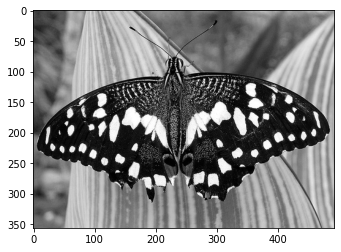

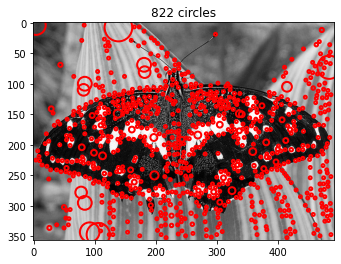

In [88]:
image = 'assignment2_images/butterfly.jpg'
# image = 'assignment2_images/fishes.jpg'
# image = 'assignment2_images/einstein.jpg'
# image = "assignment2_images/sunflowers.jpg"
# image = "assignment2_images/balloons.jpeg"
# image = "assignment2_images/car.jpeg"
# image = "assignment2_images/gandam.jpeg"
# image = "assignment2_images/grapes.jpeg"

sigma = 2
k = np.sqrt(2)
# k = 2
levels = 4
# levels = 12
octave = 5
thres = 0.001

im = load_gray_image(image)
plt.imshow(im, cmap="gray")
t1 = time.time()
scale_space = dog_blob2(im, sigma=sigma, levels=levels, octave=octave)
print("Time for {} when computing DoG: {}".format(method, time.time()-t1))
act_map  = nms(scale_space, thres=thres)
print("Time for detecting blobs: {}".format(time.time()-t1))
cx, cy, rad = get_circle_info(act_map, sigma=sigma, levels=levels, octave=octave)
show_all_circles(im, cx, cy, rad)